In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc, warnings
import random
import datetime

from tqdm.notebook import tqdm
# matplotlib and seaborn for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# from plotly.offline import init_notebook_mode, iplot
# init_notebook_mode(connected=True)
# import plotly.graph_objs as go
# import plotly.offline as offline
# offline.init_notebook_mode()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
import sklearn

import lightgbm as lgb

import pickle

warnings.filterwarnings('ignore')

In [2]:
path = '../input/ashrae-energy-prediction'
# Input data files are available in the "../input/" directory.
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input/ashrae-energy-prediction/sample_submission.csv
../input/ashrae-energy-prediction/building_metadata.csv
../input/ashrae-energy-prediction/weather_train.csv
../input/ashrae-energy-prediction/weather_test.csv
../input/ashrae-energy-prediction/train.csv
../input/ashrae-energy-prediction/test.csv


In [3]:
# unimportant features (see importance below)
unimportant_cols = ['wind_direction', 'wind_speed', 'sea_level_pressure']
target = 'meter_reading'

def load_data(source='train', path=path):
    ''' load and merge all tables '''
    assert source in ['train', 'test']
    
    building = pd.read_csv(f'{path}/building_metadata.csv', dtype={'building_id':np.uint16, 'site_id':np.uint8})
    weather  = pd.read_csv(f'{path}/weather_{source}.csv', parse_dates=['timestamp'],
                                                           dtype={'site_id':np.uint8, 'air_temperature':np.float16,
                                                                  'cloud_coverage':np.float16, 'dew_temperature':np.float16,
                                                                  'precip_depth_1_hr':np.float16},
                                                           usecols=lambda c: c not in unimportant_cols)
    df = pd.read_csv(f'{path}/{source}.csv', dtype={'building_id':np.uint16, 'meter':np.uint8}, parse_dates=['timestamp'])
    df = df.merge(building, on='building_id', how='left')
    df = df.merge(weather, on=['site_id', 'timestamp'], how='left')
    return df

In [4]:
%%time
train = load_data('train')
train.head(7)

CPU times: user 18.4 s, sys: 3.97 s, total: 22.3 s
Wall time: 26.7 s


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN
5,5,0,2016-01-01,0.0,0,Education,8000,2000.0,NaN,25.0,6.0,20.0,NaN
6,6,0,2016-01-01,0.0,0,Lodging/residential,27926,1981.0,NaN,25.0,6.0,20.0,NaN


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 13 columns):
 #   Column             Dtype         
---  ------             -----         
 0   building_id        uint16        
 1   meter              uint8         
 2   timestamp          datetime64[ns]
 3   meter_reading      float64       
 4   site_id            uint8         
 5   primary_use        object        
 6   square_feet        int64         
 7   year_built         float64       
 8   floor_count        float64       
 9   air_temperature    float16       
 10  cloud_coverage     float16       
 11  dew_temperature    float16       
 12  precip_depth_1_hr  float16       
dtypes: datetime64[ns](1), float16(4), float64(3), int64(1), object(1), uint16(1), uint8(2)
memory usage: 1.3+ GB


In [6]:
%%time
test = load_data('test')
test.sample(7)

CPU times: user 41.4 s, sys: 10.5 s, total: 51.9 s
Wall time: 1min 1s


,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr
16694877,16694877,774,0,2017-07-04 15:00:00,6,Lodging/residential,93500,NaN,NaN,27.796875,0.0,20.593750,0.0
39691170,39691170,1367,0,2018-03-02 14:00:00,15,Education,33695,1948.0,NaN,-2.199219,NaN,-3.300781,-1.0
17414595,17414595,750,1,2018-07-14 16:00:00,6,Education,35990,NaN,NaN,28.906250,2.0,18.906250,0.0
38495194,38495194,1379,2,2017-08-10 19:00:00,15,Office,49553,1963.0,NaN,26.703125,4.0,12.796875,NaN
30773554,30773554,1143,2,2018-06-28 21:00:00,13,Office,96612,NaN,NaN,30.000000,NaN,20.593750,0.0
16383779,16383779,787,0,2017-01-23 14:00:00,6,Lodging/residential,278795,NaN,NaN,8.898438,NaN,7.199219,41.0
14837430,14837430,703,0,2017-01-15 17:00:00,5,Education,34563,1966.0,1.0,9.000000,NaN,7.000000,NaN


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 13 columns):
 #   Column             Dtype         
---  ------             -----         
 0   row_id             int64         
 1   building_id        uint16        
 2   meter              uint8         
 3   timestamp          datetime64[ns]
 4   site_id            uint8         
 5   primary_use        object        
 6   square_feet        int64         
 7   year_built         float64       
 8   floor_count        float64       
 9   air_temperature    float16       
 10  cloud_coverage     float16       
 11  dew_temperature    float16       
 12  precip_depth_1_hr  float16       
dtypes: datetime64[ns](1), float16(4), float64(2), int64(2), object(1), uint16(1), uint8(2)
memory usage: 2.6+ GB


#  FULL EDA

**Data Wrangling**

In [8]:
buildings = pd.read_csv('../input/ashrae-energy-prediction/building_metadata.csv')
buildings.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [9]:
print("NULL COUNT:" )
print(buildings.isnull().sum())
print("DUPLICATES COUNT:" )
print(buildings.duplicated().sum())

NULL COUNT:
site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64
DUPLICATES COUNT:
0


In [10]:
import plotly.express as px
  
fig = px.box(buildings, x = "primary_use", y="square_feet")
fig.show()

# Meter Readings Visual Train

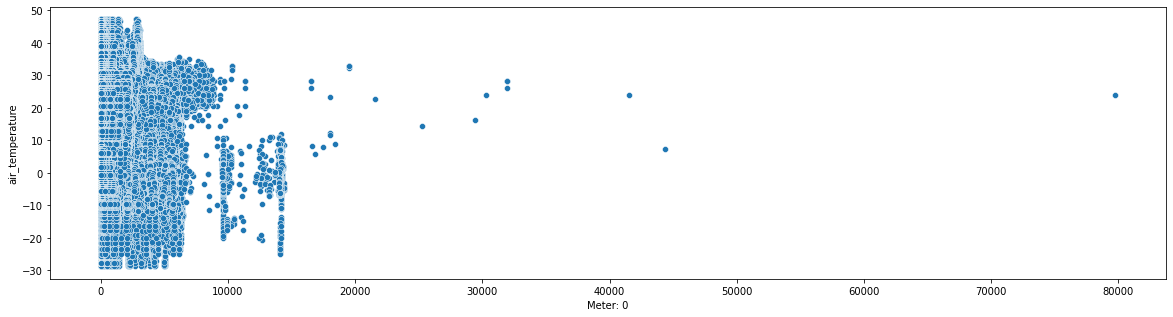

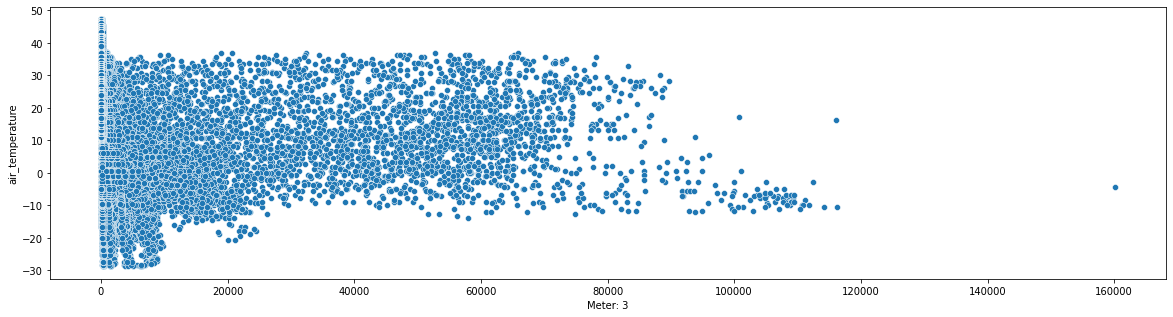

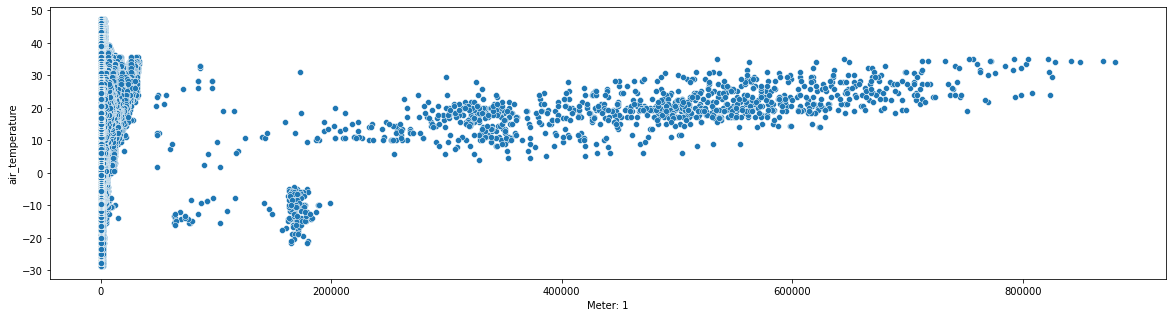

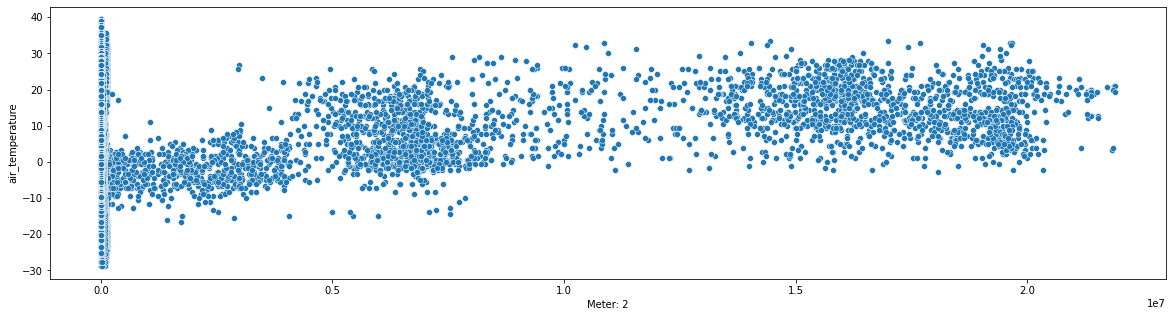

In [11]:
meter_arr = train["meter"].unique()
for meter in meter_arr:
    mask = train["meter"] == meter
    plt.figure(figsize=(20, 5))
    sns.scatterplot(data = train[mask], x = "meter_reading", y = "air_temperature")
    plt.xlabel("Meter: {}".format(meter))
    plt.show()

**Removing Outliers**

In [12]:
mask1 = train["meter"] == 0
mask2 = train["meter_reading"] > 40000
mask = np.logical_and(mask1, mask2)
print(train.shape)
train[mask]["meter_reading"] = np.mean(train[mask1]["meter_reading"])
print(train.shape)

(20216100, 13)
(20216100, 13)


In [13]:
mask1 = train["meter"] == 3
mask2 = train["meter_reading"] > 140000
mask = np.logical_and(mask1, mask2)
print(train.shape)
train[mask]["meter_reading"] = np.mean(train[mask1]["meter_reading"])
print(train.shape)

(20216100, 13)
(20216100, 13)


Train meter 1 and 2 have no visual outliers

In [14]:
train.corr().meter

building_id          0.222268
meter                1.000000
meter_reading        0.017672
site_id              0.253875
square_feet          0.132708
year_built          -0.003798
floor_count          0.176926
air_temperature     -0.011158
cloud_coverage      -0.177186
dew_temperature     -0.080445
precip_depth_1_hr   -0.002283
Name: meter, dtype: float64

In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 13 columns):
 #   Column             Dtype         
---  ------             -----         
 0   row_id             int64         
 1   building_id        uint16        
 2   meter              uint8         
 3   timestamp          datetime64[ns]
 4   site_id            uint8         
 5   primary_use        object        
 6   square_feet        int64         
 7   year_built         float64       
 8   floor_count        float64       
 9   air_temperature    float16       
 10  cloud_coverage     float16       
 11  dew_temperature    float16       
 12  precip_depth_1_hr  float16       
dtypes: datetime64[ns](1), float16(4), float64(2), int64(2), object(1), uint16(1), uint8(2)
memory usage: 2.6+ GB


**exploring test file**

In [16]:
#The goal is to predict the meter reading column accurately
# not much exploartion is needed in the test file 
# exploring should be after the prediction

In [17]:
le = LabelEncoder()
train["primary_use"] = le.fit_transform(train["primary_use"])

In [18]:
train['hour'] = np.uint8(train['timestamp'].dt.hour)
train['day'] = np.uint8(train['timestamp'].dt.day)
train['weekday'] = np.uint8(train['timestamp'].dt.weekday)
train['month'] = np.uint8(train['timestamp'].dt.month)
train['year'] = np.uint8(train['timestamp'].dt.year-2000)
train = train.drop("timestamp", axis = 1)

In [19]:
emptylist = []
for col in train.columns:
    max1 = train[col].max()
    min1 = train[col].min()
    if not np.isfinite(train[col]).all(): 
        emptylist.append(col)
        train[col].fillna(min1-1,inplace=True)

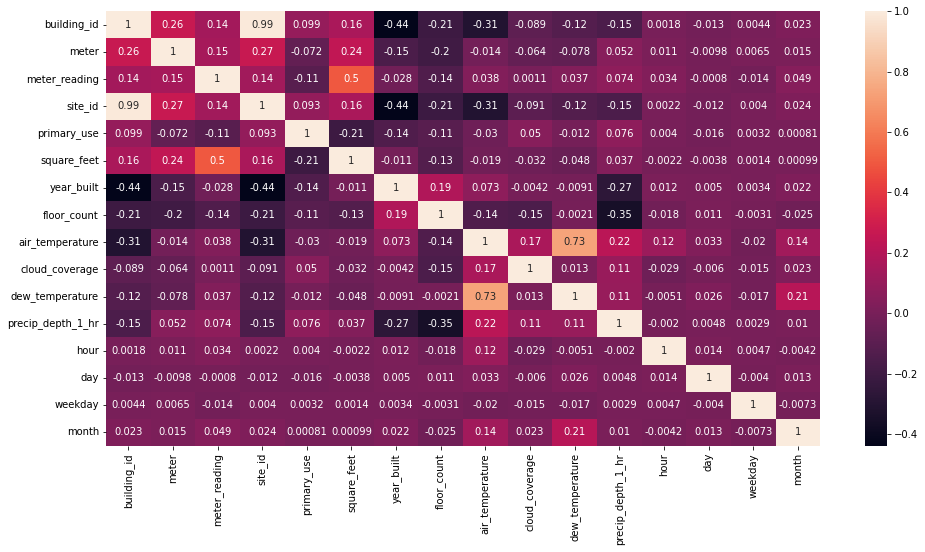

In [20]:
fig, ax = plt.subplots(figsize=(16,8))

corr = train[[col for col in train.columns if col != 'year']].sample(10000).corr(method='spearman')
_ = sns.heatmap(corr, annot=True, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [21]:
target = np.log1p(train["meter_reading"])
train = train.drop(["meter_reading"],axis=1)

In [22]:
from sklearn.model_selection import train_test_split 
xtrain, xval, ytrain, yval = train_test_split(train, target, test_size=0.3, random_state=42)
RFRxtrain, RFRxtest, RFRytrain, RFRytest = train_test_split(train, target, test_size=0.995, random_state=42)
RFRxtrain, RFRxtest, RFRytrain, RFRytest = train_test_split(RFRxtrain, RFRytrain, test_size=0.3, random_state=42)

In [23]:
from sklearn import metrics
from sklearn.linear_model  import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,  mean_absolute_error
from sklearn.model_selection import cross_validate, KFold, RandomizedSearchCV, GridSearchCV, train_test_split


In [24]:
model = DecisionTreeRegressor(max_depth=30)
model.fit(xtrain, ytrain)
# This takes around ... minutes to run

DecisionTreeRegressor(max_depth=30)

In [25]:
ypred_val = model.predict(xval)

Text(0, 0.5, 'Predicted meter reading')

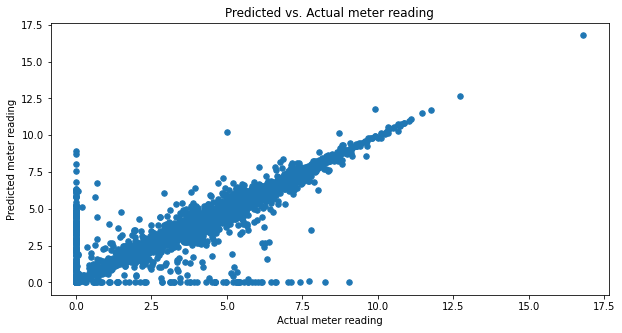

In [26]:
plt.figure(figsize=(10, 5))
plt.scatter(yval[0:10000], ypred_val[0:10000], s=30)
plt.title('Predicted vs. Actual meter reading')
plt.xlabel('Actual meter reading')
plt.ylabel('Predicted meter reading')

In [27]:
SGDreg   =  SGDRegressor(random_state = 42)
SGDreg.fit(xtrain, ytrain.ravel())
y_pred=SGDreg.predict(xval)

Text(0, 0.5, 'Predicted meter reading')

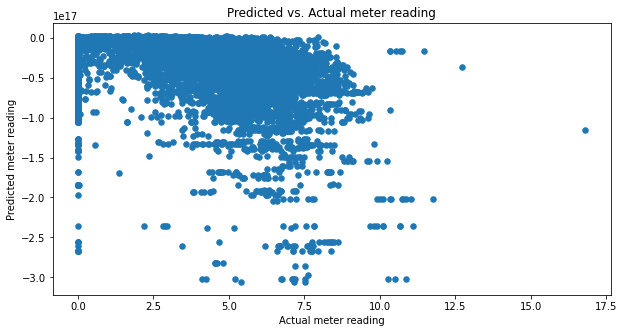

In [28]:
plt.figure(figsize=(10, 5))
plt.scatter(yval[0:10000], y_pred[0:10000], s=30)
plt.title('Predicted vs. Actual meter reading')
plt.xlabel('Actual meter reading')
plt.ylabel('Predicted meter reading')

In [29]:
def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [30]:
reduce_memory_usage(RFRxtrain)
reduce_memory_usage(RFRxtest)

Mem. usage decreased to  2.29 Mb (40.4% reduction)
Mem. usage decreased to  0.98 Mb (40.4% reduction)


,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,hour,day,weekday,month,year
16123908,1212,1,13,9,237518,1899.0,0.0,11.101562,4.0,3.900391,0.0,22,19,2,10,16
8306931,1177,1,13,6,20444,1899.0,0.0,18.906250,4.0,8.296875,0.0,17,2,3,6,16
242552,953,1,9,1,563782,1899.0,0.0,2.800781,0.0,0.000000,0.0,9,5,1,1,16
12001352,1366,1,15,6,87977,1947.0,0.0,18.906250,0.0,16.093750,-2.0,12,7,6,8,16
3300683,337,0,3,1,22334,1977.0,0.0,4.398438,2.0,-8.898438,0.0,22,2,2,3,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12015125,1306,1,14,4,54172,1899.0,0.0,28.906250,0.0,15.601562,0.0,18,7,6,8,16
12452340,901,2,9,0,107730,1899.0,0.0,23.296875,-1.0,22.796875,18.0,19,15,0,8,16
18543139,257,0,2,0,75650,1899.0,0.0,15.601562,4.0,-5.601562,0.0,0,2,4,12,16
12233934,43,1,0,11,59071,1980.0,0.0,32.187500,-1.0,22.203125,0.0,19,11,3,8,16


In [31]:
RFRreg = RandomForestRegressor(n_estimators = 100, random_state = 0)
RFRreg.fit(RFRxtrain, RFRytrain)


RandomForestRegressor(random_state=0)

In [32]:
RFR_ypred = RFRreg.predict(RFRxtest)

Text(0, 0.5, 'Predicted meter reading')

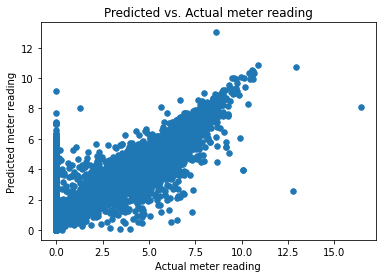

In [33]:
plt.scatter(RFRytest[0:10000], RFR_ypred[0:10000], s=30)
plt.title('Predicted vs. Actual meter reading')
plt.xlabel('Actual meter reading')
plt.ylabel('Predicted meter reading')